## Executive Summary

In this notebook, I study the NYC taxi industry focusing on the taxi trip data in 2019 and 2020. Below are my main findings.

1. Using a DID model, I have estimated the impact of Covid-19 on the yellow taxi fare amount pre and post 2019. I find that the pandemic causes the monthly market fare volume to drop by about -74.1 million. The tip amount also drops down during the pandemic and it gradually recovers since Jun 2020. During Covid-19, passengers tend to use taxi service more when longer travel distance is involved, and are less likely to travel across the congestion zone. In order to keep social distance, lower average passengers per trip is also observed.
2. In 2019, the month of the year with the highest average tip is Feb, in terms of percentage. The day of the week with the highest tip in 2019 is a Friday and the transaction hour is 9 pm.
3. Using only 2019 and 2020 yellow taxi transaction data. The average tip from LGA is 5.52 dollars and the average tip from JFK is 5.85 dollars.
4. By comparing the market fare volume in the first half of 2019 and 2020 in the yellow cab transaction data, I can see that the taxi market is shrinking. This is partly due to the impact of Covid-19. However, from the DID regression, the year 2020 indicator has a negative coefficient. This suggests that there are other factors inducing the shrinkage of taxi transactions. One conjecture is that mobile app like Uber and Lyft has a substitution effect on the taxi.

In [4]:
import requests
import numpy as np
import pandas as pd

In [5]:
from urllib.error import HTTPError

## Question 1: Study the impact of Covid-19

Due the limited capacity of computer, I need to do some preprocessing in order to run my analysis

In [5]:
data2020 = pd.DataFrame()
for j in range (1, 7):
    url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-{}.csv'.format(str(j).zfill(2))
    try:
        df = pd.read_csv(url)
        df['pick_date']= df['tpep_pickup_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
        df['pick_hour']= df['tpep_pickup_datetime'].apply(lambda x: x[11:13]).astype(int)
        df['pick_minute']= df['tpep_pickup_datetime'].apply(lambda x: x[14:16]).astype(int)
        df['dropoff_date']= df['tpep_dropoff_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
        df['dropoff_hour']= df['tpep_dropoff_datetime'].apply(lambda x: x[11:13]).astype(int)
        df['dropoff_minute']= df['tpep_dropoff_datetime'].apply(lambda x: x[14:16]).astype(int)
        df['store_and_fwd_flag']= df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
        del df['tpep_dropoff_datetime']
        del df['tpep_pickup_datetime']
    except HTTPError:
        df=pd.DataFrame()
    data2020=pd.concat([data2020, df])

C:\Users\esper\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
data2020.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16847778 entries, 0 to 549759
Data columns (total 22 columns):
VendorID                 float64
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag       float64
PULocationID             int64
DOLocationID             int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
pick_date                int32
pick_hour                int32
pick_minute              int32
dropoff_date             int32
dropoff_hour             int32
dropoff_minute           int32
dtypes: float64(14), int32(6), int64(2)
memory usage: 2.5 GB


In [7]:
data2020['store_and_fwd_flag']=data2020['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

In [8]:
# Drop memory usage
float_cols=data2020.select_dtypes(include=['float']).columns
int_cols=data2020.select_dtypes(include=['int']).columns
data2020[float_cols]=data2020[float_cols].apply(pd.to_numeric,downcast='float')
data2020[int_cols]=data2020[int_cols].apply(pd.to_numeric,downcast='unsigned')

In [9]:
data2020.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16847778 entries, 0 to 549759
Data columns (total 22 columns):
VendorID                 float32
passenger_count          float32
trip_distance            float32
RatecodeID               float32
store_and_fwd_flag       float32
PULocationID             int64
DOLocationID             int64
payment_type             float32
fare_amount              float32
extra                    float32
mta_tax                  float32
tip_amount               float32
tolls_amount             float32
improvement_surcharge    float32
total_amount             float32
congestion_surcharge     float32
pick_date                uint32
pick_hour                uint8
pick_minute              uint8
dropoff_date             uint32
dropoff_hour             uint8
dropoff_minute           uint8
dtypes: float32(14), int64(2), uint32(2), uint8(4)
memory usage: 1.4 GB


In [10]:
import gc

In [26]:
gc.collect()

832

In [12]:
data2019 = pd.DataFrame()
for j in range (1, 7):
    url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-{}.csv'.format(str(j).zfill(2))
    try:
        df = pd.read_csv(url)
        df['pick_date']= df['tpep_pickup_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
        df['pick_hour']= df['tpep_pickup_datetime'].apply(lambda x: x[11:13]).astype(int)
        df['pick_minute']= df['tpep_pickup_datetime'].apply(lambda x: x[14:16]).astype(int)
        df['dropoff_date']= df['tpep_dropoff_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
        df['dropoff_hour']= df['tpep_dropoff_datetime'].apply(lambda x: x[11:13]).astype(int)
        df['dropoff_minute']= df['tpep_dropoff_datetime'].apply(lambda x: x[14:16]).astype(int)
        df['store_and_fwd_flag']= df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
        del df['tpep_dropoff_datetime']
        del df['tpep_pickup_datetime']
    except HTTPError:
        df=pd.DataFrame()
    data2019=pd.concat([data2019, df])

In [13]:
data2020.shape

(16847778, 22)

In [14]:
data2019.shape

(44459136, 22)

In [15]:
# Drop memory usage
float_cols=data2019.select_dtypes(include=['float']).columns
int_cols=data2019.select_dtypes(include=['int']).columns
data2019[float_cols]=data2019[float_cols].apply(pd.to_numeric,downcast='float')
data2019[int_cols]=data2019[int_cols].apply(pd.to_numeric,downcast='unsigned')

### Distribution analysis of related columns

In [17]:
data2019[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', \
          'total_amount', 'congestion_surcharge', 'trip_distance', 'passenger_count',]].quantile(0.99)

fare_amount              52.000000
extra                     3.500000
mta_tax                   0.500000
tip_amount               12.280000
tolls_amount              6.120000
improvement_surcharge     0.300000
total_amount             73.699997
congestion_surcharge      2.500000
trip_distance            19.129999
passenger_count           6.000000
Name: 0.99, dtype: float64

In [18]:
data2019[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', \
          'total_amount', 'congestion_surcharge', 'trip_distance', 'passenger_count',]].quantile(0.1)

fare_amount              5.0
extra                    0.0
mta_tax                  0.5
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.3
total_amount             8.5
congestion_surcharge     0.0
trip_distance            0.6
passenger_count          1.0
Name: 0.1, dtype: float64

In [19]:
data2019[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', \
          'total_amount', 'congestion_surcharge', 'trip_distance', 'passenger_count',]].describe()

,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_distance,passenger_count
count,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,4.445914e+07,3.960316e+07,4.445914e+07,4.445914e+07
mean,1.043571e+01,9.778316e-01,1.887021e-01,1.888245e+00,3.679373e-01,1.886813e-01,1.415050e+01,1.694533e+00,2.355626e+00,1.570669e+00
std,2.226261e+02,1.164218e+00,2.213706e-01,2.129703e+01,1.738444e+00,7.856438e-02,2.367114e+02,7.533320e-01,7.835433e+00,1.222896e+00
min,-4.500800e+02,-6.000000e+01,-5.000000e-01,-8.989000e+01,-7.000000e+01,-3.000000e-01,-4.508800e+02,-2.500000e+00,0.000000e+00,0.000000e+00
25%,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00,9.700000e-01,1.000000e+00
50%,9.500000e+00,5.000000e-01,5.000000e-01,1.800000e+00,0.000000e+00,3.000000e-01,1.416000e+01,2.500000e+00,1.600000e+00,1.000000e+00
75%,1.450000e+01,2.500000e+00,5.000000e-01,2.860000e+00,0.000000e+00,3.000000e-01,2.015000e+01,2.500000e+00,3.000000e+00,2.000000e+00
max,9.432748e+05,5.353800e+02,2.124200e+02,1.414920e+05,3.288000e+03,1.000000e+00,1.084772e+06,4.500000e+00,4.597722e+04,9.000000e+00


In [20]:
data2020[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', \
          'total_amount', 'congestion_surcharge', 'trip_distance', 'passenger_count', ]].describe()

,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_distance,passenger_count
count,1.684778e+07,1.684778e+07,1.684778e+07,1.684778e+07,1.684778e+07,1.684778e+07,1.684778e+07,1.684778e+07,1.684778e+07,1.656690e+07
mean,1.254642e+01,1.051401e+00,4.979066e-01,2.152633e+00,3.301388e-01,2.710712e-01,1.843700e+01,1.900231e+00,2.984016e+00,1.289111e+00
std,1.944050e+02,1.218201e+02,1.218144e+02,2.740509e+00,1.670157e+00,3.980464e-02,3.117717e+02,8.147768e-01,1.679257e+02,1.134579e+00
min,-1.259000e+03,-2.700000e+01,-5.000000e-01,-4.932200e+02,-4.000000e+01,-3.000000e-01,-1.260300e+03,-2.500000e+00,-3.062000e+01,0.000000e+00
25%,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00,9.700000e-01,1.000000e+00
50%,9.000000e+00,5.000000e-01,5.000000e-01,1.920000e+00,0.000000e+00,3.000000e-01,1.430000e+01,2.500000e+00,1.610000e+00,1.000000e+00
75%,1.400000e+01,2.500000e+00,5.000000e-01,2.860000e+00,0.000000e+00,3.000000e-01,2.000000e+01,2.500000e+00,3.000000e+00,2.000000e+00
max,6.711001e+05,5.000008e+05,5.000005e+05,1.100000e+03,9.255000e+02,3.000000e-01,1.000004e+06,2.750000e+00,2.970045e+05,9.000000e+00


#### Summary of findings
The 'fare_amount', 'tip_amount', and 'congestion_surchange' are the three most important parts in 'total_amount'. I will focus my analysis on these columns.

In [18]:
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

In [20]:
data2019['YYYYMM']=data2019['pick_date'].astype(str).apply(lambda x: x[0:6]).astype(int)
data2020['YYYYMM']=data2020['pick_date'].astype(str).apply(lambda x: x[0:6]).astype(int)

In [21]:
data2020=data2020[(data2020['YYYYMM']>201912) & (data2020['YYYYMM']<202007)]
data2019=data2019[(data2019['YYYYMM']>201812)]

In [22]:
size2019=data2019[(data2019['YYYYMM']<201907)].groupby('YYYYMM')['fare_amount'].sum().reset_index()
size2020=data2020.groupby('YYYYMM')['fare_amount'].sum().reset_index()

In [23]:
meanfare2019=data2019[(data2019['YYYYMM']<201907)].groupby('YYYYMM')['fare_amount'].mean().reset_index()
meanfare2020=data2020.groupby('YYYYMM')['fare_amount'].mean().reset_index()

In [27]:
tip2019=data2019[(data2019['YYYYMM']<201907)].groupby('YYYYMM')['tip_amount'].mean().reset_index()
tip2020=data2020.groupby('YYYYMM')['tip_amount'].mean().reset_index()

In [45]:
total2019=data2019[(data2019['YYYYMM']<201907)].groupby('YYYYMM')['total_amount'].sum().reset_index()
total2020=data2020.groupby('YYYYMM')['total_amount'].sum().reset_index()

In [28]:
congestion2019=data2019[(data2019['YYYYMM']<201907)].groupby('YYYYMM')['congestion_surcharge'].mean().reset_index()
congestion2020=data2020.groupby('YYYYMM')['congestion_surcharge'].mean().reset_index()

In [29]:
distance2019=data2019[(data2019['YYYYMM']<201907)].groupby('YYYYMM')['trip_distance'].mean().reset_index()
distance2020=data2020.groupby('YYYYMM')['trip_distance'].mean().reset_index()

In [30]:
ppl2019=data2019[(data2019['YYYYMM']<201907)].groupby('YYYYMM')['passenger_count'].mean().reset_index()
ppl2020=data2020.groupby('YYYYMM')['passenger_count'].mean().reset_index()

In [31]:
gc.collect()

112

### Comparing fare amount

Text(0.5,1,'Histogram of fare volume pre and post Covid-19')

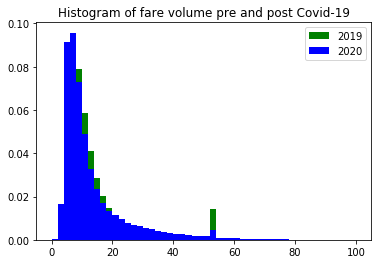

In [33]:
fig = plt.figure()
plt.hist(data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904) & (data2019['fare_amount']<=100) & (data2019['fare_amount']>=0)]['fare_amount'], 50, color='g', label='2019', normed=True)
plt.hist(data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004) & (data2020['fare_amount']<=100) & (data2020['fare_amount']>=0)]['fare_amount'], 50, color='b', label='2020', normed=True)
plt.legend()
plt.title('Histogram of fare volume pre and post Covid-19')

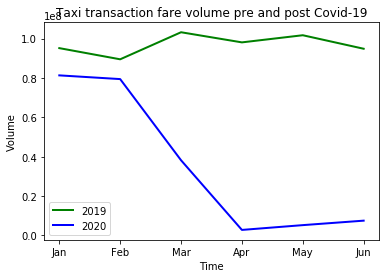

In [34]:
fig = plt.figure()
plt.plot(size2019.index, size2019['fare_amount'], 'g', label='2019', linewidth=2)
plt.plot(size2020.index, size2020['fare_amount'], 'b', label='2020', linewidth=2)
plt.title('Taxi transaction fare volume pre and post Covid-19')
plt.xticks(np.arange(6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.ylabel('Volume')
plt.xlabel('Time')
plt.legend()

Summary: The distribution of the fare amount in 2019Q2 and 2020Q2 are quite similar. In 2019, the distribution of the fare amount has a little spike around 53-55 while in 2020, the spike around 53-55 is less prominent.
The parallel trend in Jan and Feb shows that we may use the DID model quantitatively estimate the impact of Covid-19 on the fare volume of the yellow cab. I will run a DID to quantify the impact. The control group is the yellow cab transaction in 2019Q1 and 2019Q2. Note that the parallel trend assumption can be more rigorously tested using data in previous years. The estimation of Covid-19 impact can be more accurately estimated using observations in previous years. The following DID regression is a Demo of what I plan to do. Due to the capacity of Computer RAM and time limit, I will not extend to the full version of model estimate.


### Constructing DID dataset

In [35]:
size2019['is_2020']=0
size2019['month']=1+size2019.index
size2020['is_2020']=1
size2020['month']=1+size2020.index

In [36]:
diddata=pd.concat([size2019, size2020])
diddata=pd.get_dummies(diddata, columns=['month'])
diddata['is_covid']=1*(diddata['YYYYMM']>=202003)

In [37]:
diddata['intercept']=1

In [38]:
import statsmodels.api as sm

C:\Users\esper\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The DID regression equation is:

$y = \alpha + \beta_{0}\times is2020 + \beta_{1}\times month1 + \beta_{2}\times month2 + \beta_{3}\times month3 + \beta_{4}\times month4 + \beta_{5}\times month5 + \gamma \times isCovid$

Here, $\gamma$ is the estimate of the Covid-19 impact.

In [39]:
mod1 = sm.OLS(diddata['fare_amount'], diddata[['intercept', 'is_2020', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'is_covid']])

In [40]:
mod1.fit().summary()

C:\Users\esper\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     31.73
Date:                Mon, 14 Sep 2020   Prob (F-statistic):            0.00239
Time:                        15:31:56   Log-Likelihood:                -202.56
No. Observations:                  12   AIC:                             421.1
Df Residuals:                       4   BIC:                             425.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.418e+07    7.1e+06     13.269      0.000    7.45e+07    1.14e+08
is_2020    -1.195e+07   8.98e+06     -1.331      0.254   -3.69e+07     1.3e+07
month_1     1.781e+04   1.05e+07      0.002      0.999   -2.92e+07    2.92e+07
month_2    -3.764e+06   1.05e+07     -0.358      0.739    -3.3e+07    2.55e+07
month_3     1.954e+07   8.98e+06      2.177      0.095   -5.39e+06    4.45e+07
month_4     -7.34e+05   8.98e+06     -0.082      0.939   -2.57e+07    2.42e+07
month_5     2.295e+06   8.98e+06      0.256      0.811   -2.26e+07    2.72e+07
is_covid    -7.41e+07    1.1e+07     -6.739      0.003   -1.05e+08   -4.36e+07
==============================================================================
Omnibus:                        0.759   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.684   Jarque-Bera (JB):                0.004
Skew:                          -0.000   Prob(JB):                        0.998
Kurtosis:                       3.087   Cond. No.                         9.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Summary: The 'is_covid' variable shows that the Covid impact on the monthly market fare volume in the yellow taxi industry is about -74.1 million. 
Considering removing the observations in March since the New York City shuts down in the middle of March and reestimating the DID model.

In [41]:
mod2 = sm.OLS(diddata[diddata['month_3']!=1]['fare_amount'],diddata[diddata['month_3']!=1][['intercept', 'is_2020', 'month_1', 'month_2',
        'month_4', 'month_5', 'is_covid']])

In [42]:
mod2.fit().summary()

C:\Users\esper\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     283.7
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           0.000322
Time:                        15:32:08   Log-Likelihood:                -157.54
No. Observations:                  10   AIC:                             329.1
Df Residuals:                       3   BIC:                             331.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.768e+07   2.51e+06     38.977      0.000    8.97e+07    1.06e+08
is_2020    -1.195e+07   3.07e+06     -3.893      0.030   -2.17e+07   -2.18e+06
month_1    -3.483e+06   3.65e+06     -0.953      0.411   -1.51e+07    8.14e+06
month_2    -7.265e+06   3.65e+06     -1.988      0.141   -1.89e+07    4.36e+06
month_4     -7.34e+05   3.07e+06     -0.239      0.826   -1.05e+07    9.03e+06
month_5     2.295e+06   3.07e+06      0.748      0.509   -7.47e+06    1.21e+07
is_covid    -8.11e+07   3.96e+06    -20.467      0.000   -9.37e+07   -6.85e+07
==============================================================================
Omnibus:                        0.408   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.463
Skew:                           0.000   Prob(JB):                        0.793
Kurtosis:                       1.946   Cond. No.                         8.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Summary: The estimates is -81.1 million which is within one standard deviation of the previous estimates.

### Comparing total_amount

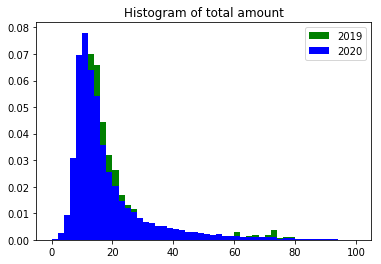

In [43]:
fig = plt.figure()
plt.hist(data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904) & (data2019['total_amount']<=100) & (data2019['total_amount']>=0)]['total_amount'], 50, color='g',label='2019',  normed=True)
plt.hist(data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004) & (data2020['total_amount']<=100) & (data2020['total_amount']>=0)]['total_amount'], 50, color='b', label='2020', normed=True)
plt.title('Histogram of total amount')
plt.legend()

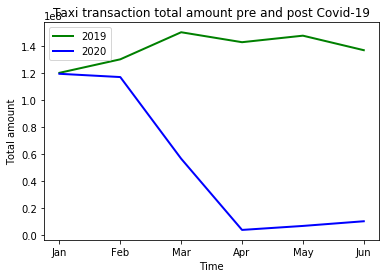

In [46]:
fig = plt.figure()
plt.plot(total2019.index, total2019['total_amount'], 'g', label='2019', linewidth=2)
plt.plot(total2020.index, total2020['total_amount'], 'b', label='2020', linewidth=2)
plt.title('Taxi transaction total amount pre and post Covid-19')
plt.xticks(np.arange(6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.ylabel('Total amount')
plt.xlabel('Time')
plt.legend()

In [47]:
total2019[total2019['YYYYMM']>=201904]['total_amount'].mean()-total2020[total2020['YYYYMM']>=202004]['total_amount'].mean()

135548989.5

Summary: Here the total amount in 2019 and 2020 does not seem to satisfy the parallel trend assumption. I am refrained from using the DID model to do the estimation. By computing the total monthly volume in 2019Q2 and 2020Q2, we can see that it has dropped by 135.55 million.

### Comparing tip amount

Text(0.5,1,'Histogram of tip amount')

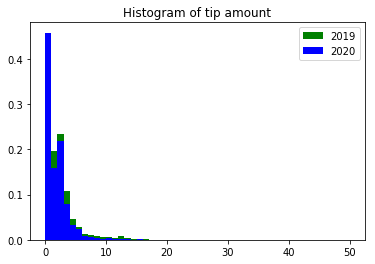

In [48]:
# Histogram of total amount in 2020
fig = plt.figure()
plt.hist(data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904) & (data2019['tip_amount']<=50) & (data2019['tip_amount']>=0)]['tip_amount'], 50, color='g', label='2019', normed=True)
plt.hist(data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004) & (data2020['tip_amount']<=50) & (data2020['tip_amount']>=0)]['tip_amount'], 50, color='b', label='2020',normed=True)
plt.legend()
plt.title('Histogram of tip amount')

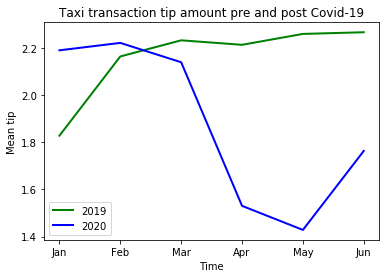

In [49]:
fig = plt.figure()
plt.plot(tip2019.index, tip2019['tip_amount'], 'g', label='2019', linewidth=2)
plt.plot(tip2020.index, tip2020['tip_amount'], 'b', label='2020', linewidth=2)
plt.title('Taxi transaction tip amount pre and post Covid-19')
plt.xticks(np.arange(6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.ylabel('Mean tip')
plt.xlabel('Time')
plt.legend()

In [50]:
data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904)]['tip_amount'].mean()-\
data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004)]['tip_amount'].mean()

0.6408277750015259

Summary: Here the average tip in 2019 and 2020 does not seem to satisfy the parallel trend assumption. I am refrained from using the DID model to do the estimation. By computing the average tip amount in 2019Q2 and 2020Q2 respectively, we can see that it has dropped by 0.64.

### Comparing congestion surcharge

Text(0.5,1,'Histogram of congestion surcharge')

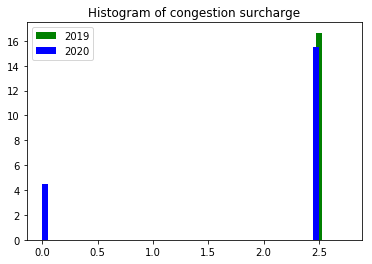

In [51]:
fig = plt.figure()
plt.hist(data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904) & (data2019['congestion_surcharge']<=10) & (data2019['congestion_surcharge']>=0)]['congestion_surcharge'], 50, label='2019', color='g', normed=True)
plt.hist(data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004) & (data2020['congestion_surcharge']<=10) & (data2020['congestion_surcharge']>=0)]['congestion_surcharge'], 50, label='2020', color='b', normed=True)
plt.legend()
plt.title('Histogram of congestion surcharge')

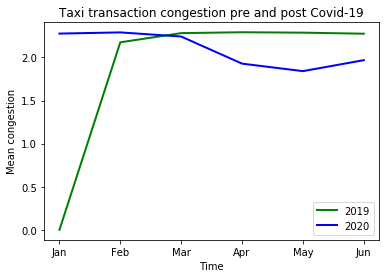

In [52]:
fig = plt.figure()
plt.plot(congestion2019.index, congestion2019['congestion_surcharge'], 'g', label='2019', linewidth=2)
plt.plot(congestion2020.index, congestion2020['congestion_surcharge'], 'b', label='2020', linewidth=2)
plt.title('Taxi transaction congestion pre and post Covid-19')
plt.xticks(np.arange(6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.ylabel('Mean congestion')
plt.xlabel('Time')
plt.legend()

In [53]:
data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904)]['congestion_surcharge'].mean()-\
data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004)]['congestion_surcharge'].mean()

0.35817086696624756

Summary: Here the average tip in 2019 and 2020 does not seem to satisfy the parallel trend assumption. I am refrained from using the DID model to do the estimation. By computing the average congestion surcharge amount in 2019Q2 and 2020Q2, we can see that it has dropped by 0.36. This could due to that fewer taxis are passing through the congestion zone.

### Comparing travel distance

Text(0.5,1,'Histogram of travel distance')

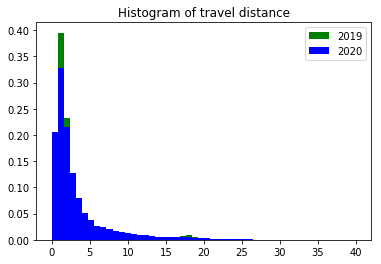

In [54]:
fig = plt.figure()
plt.hist(data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904) & (data2019['trip_distance']<=40) & (data2019['trip_distance']>=0)]['trip_distance'], 50, color='g', label='2019', normed=True)
plt.hist(data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004) & (data2020['trip_distance']<=40) & (data2020['trip_distance']>=0)]['trip_distance'], 50, color='b', label='2020', normed=True)
plt.legend()
plt.title('Histogram of travel distance')

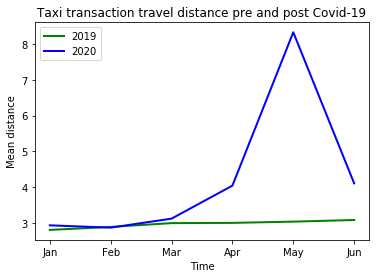

In [55]:
fig = plt.figure()
plt.plot(distance2019.index, distance2019['trip_distance'], 'g', label='2019', linewidth=2)
plt.plot(distance2020.index, distance2020['trip_distance'], 'b', label='2020', linewidth=2)
plt.title('Taxi transaction travel distance pre and post Covid-19')
plt.xticks(np.arange(6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.ylabel('Mean distance')
plt.xlabel('Time')
plt.legend()

In [56]:
data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904)]['trip_distance'].mean()-\
data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004)]['trip_distance'].mean()

-2.5518085956573486

Summary: Using the average travel distance per trip in Jan, Feb and March, we can see that there is not much difference between 2019 and 2020. However, post Covid-19, in Apr, May, and Jun, the average travel distance is much longer. This could due to that people tend to use taxi only when the travel distance is long. On average, post Covid-19, the average travel distance per trip has gone up by 2.55 miles.  

### Comparing passenger counts

Text(0.5,1,'Histogram of passenger counts')

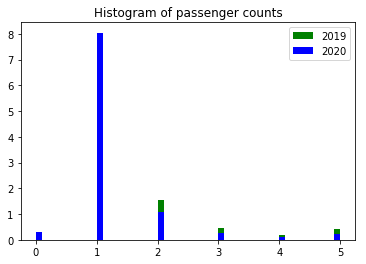

In [57]:
fig = plt.figure()
plt.hist(data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904) & (data2019['passenger_count']<=5) & (data2019['passenger_count']>=0)]['passenger_count'], 50, color='g', label='2019', normed=True)
plt.hist(data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004) & (data2020['passenger_count']<=5) & (data2020['passenger_count']>=0)]['passenger_count'], 50, color='b', label='2020', normed=True)
plt.legend()
plt.title('Histogram of passenger counts')

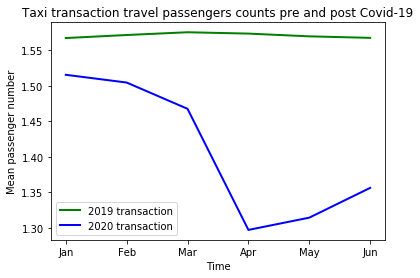

In [58]:
fig = plt.figure()
plt.plot(ppl2019.index, ppl2019['passenger_count'], 'g', label='2019 transaction', linewidth=2)
plt.plot(ppl2020.index, ppl2020['passenger_count'], 'b', label='2020 transaction', linewidth=2)
plt.title('Taxi transaction travel passengers counts pre and post Covid-19')
plt.xticks(np.arange(6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
plt.ylabel('Mean passenger number')
plt.xlabel('Time')
plt.legend()

In [59]:
data2019[(data2019['YYYYMM']<201907) & (data2019['YYYYMM']>=201904)]['passenger_count'].mean()-\
data2020[(data2020['YYYYMM']<202007) & (data2020['YYYYMM']>=202004)]['passenger_count'].mean()

0.23878678075911286

Summary: In 2019, there is not much fluctuation in average travel passengers per trip from Jan to Jun. However, in 2020, clearly, Covid-19 has induced the number of passengers per trip to go down. By computing the average passenger per trip in 2019Q2 and 2020Q2, we can see that it has dropped by 0.24. This could be that people want to keep social distance with others even when taking taxis.

## Question 2: Study 2019 cab industry

In 2019, what is the month of the year with the highest average tip, in terms of percentage? What is the day of the week with the highest tip? What is the hour of the day with the highest tip? 

Answer: In 2019, the month of the year with the highest average tip is Feb, in terms of percentage. The day of the week with the highest tip in 2019 is a Friday and the transaction hour is 9pm.

In [105]:
maxtip19=(data2019.groupby('YYYYMM')['tip_amount'].sum()/data2019.groupby('YYYYMM')['total_amount'].sum()).reset_index()

In [115]:
#Pulling out remaining data for the yellow taxi
pick={}
drop={}
tip={}
maxrecord={}
JFK=[]
LGA=[]
for j in range (7, 13):
    url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-{}.csv'.format(str(j).zfill(2))
    try:
        df = pd.read_csv(url)
        #df['pick_date']= df['tpep_pickup_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
        #df['pick_hour']= df['tpep_pickup_datetime'].apply(lambda x: x[11:13]).astype(int)
        #df['pick_minute']= df['tpep_pickup_datetime'].apply(lambda x: x[14:16]).astype(int)
        #df['dropoff_date']= df['tpep_dropoff_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
        #df['dropoff_hour']= df['tpep_dropoff_datetime'].apply(lambda x: x[11:13]).astype(int)
        #df['dropoff_minute']= df['tpep_dropoff_datetime'].apply(lambda x: x[14:16]).astype(int)
        #df['store_and_fwd_flag']= df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
        pertip=df['tip_amount'].sum()/df['total_amount'].sum()
        tip_max=df['tip_amount'].max()
        tip[str(j).zfill(2)]=pertip
        pick[str(j).zfill(2)]=df[df['tip_amount']==tip_max]['tpep_pickup_datetime'].unique()
        drop[str(j).zfill(2)]=df[df['tip_amount']==tip_max]['tpep_dropoff_datetime'].unique()
        maxrecord[str(j).zfill(2)]=tip_max
        newJFK=list(df[df['PULocationID']==132]['tip_amount'].values)
        JFK=JFK+newJFK
        newLGA=list(df[df['PULocationID']==138]['tip_amount'].values)
        LGA=LGA+newLGA
    except HTTPError:
        pass

C:\Users\esper\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
pick

{'07': array(['2019-07-24 00:46:10'], dtype=object),
 '08': array(['2019-08-04 17:50:06'], dtype=object),
 '09': array(['2019-09-06 02:20:53'], dtype=object),
 '10': array(['2019-10-12 21:49:18'], dtype=object),
 '11': array(['2019-11-15 14:26:12'], dtype=object),
 '12': array(['2019-12-20 23:24:00'], dtype=object)}

In [117]:
gc.collect()

3545

In [6]:
## Pulling out data for the green taxi
pickg={}
dropg={}
tipg={}
maxrecordg={}
JFKg=[]
LGAg=[]
for j in range (1, 13):
    url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2019-{}.csv'.format(str(j).zfill(2))
    try:
        df = pd.read_csv(url)
        #df['pick_date']= df['tpep_pickup_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
        #df['pick_hour']= df['tpep_pickup_datetime'].apply(lambda x: x[11:13]).astype(int)
        #df['pick_minute']= df['tpep_pickup_datetime'].apply(lambda x: x[14:16]).astype(int)
        #df['dropoff_date']= df['tpep_dropoff_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
        #df['dropoff_hour']= df['tpep_dropoff_datetime'].apply(lambda x: x[11:13]).astype(int)
        #df['dropoff_minute']= df['tpep_dropoff_datetime'].apply(lambda x: x[14:16]).astype(int)
        #df['store_and_fwd_flag']= df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
        pertip=df['tip_amount'].sum()/df['total_amount'].sum()
        tip_max=df['tip_amount'].max()
        tipg[str(j).zfill(2)]=pertip
        pickg[str(j).zfill(2)]=df[df['tip_amount']==tip_max]['lpep_pickup_datetime'].unique()
        dropg[str(j).zfill(2)]=df[df['tip_amount']==tip_max]['lpep_dropoff_datetime'].unique()
        maxrecordg[str(j).zfill(2)]=tip_max
        newJFKg=list(df[df['PULocationID']==132]['tip_amount'].values)
        JFKg=JFKg+newJFKg
        newLGAg=list(df[df['PULocationID']==138]['tip_amount'].values)
        LGAg=LGAg+newLGAg
    except HTTPError:
        pass

C:\Users\esper\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
tipg


{'01': 0.05377339912406731,
 '02': 0.05356390675459463,
 '03': 0.05482595885433664,
 '04': 0.06805879173849393,
 '05': 0.06811502513001469,
 '06': 0.06829758464400588,
 '07': 0.056723660045029205,
 '08': 0.05444127087550296,
 '09': 0.055709680923352496,
 '10': 0.051776026397306434,
 '11': 0.052170136112728534,
 '12': 0.050673825897358415}

In [13]:
maxrecordg

{'01': 100.0,
 '02': 440.0,
 '03': 222.22,
 '04': 399.0,
 '05': 224.56999999999999,
 '06': 151.50999999999999,
 '07': 314.0,
 '08': 400.0,
 '09': 400.0,
 '10': 158.52000000000001,
 '11': 225.0,
 '12': 441.0}

In [118]:
tip_value19a = maxtip19[maxtip19['YYYYMM']<=201906][0].max()

In [119]:
tip_value19a>max(tip.values())

True

In [120]:
maxtip19[maxtip19[0]==tip_value19a]

,YYYYMM,0
1,201902,0.116572


The yellow taxi has higher tip than the green taxi.

In [124]:
[k for k in maxrecord.keys() if maxrecord[k]==max(maxrecord.values())]


['10']

In [126]:
pick['10']


array(['2019-10-12 21:49:18'], dtype=object)

In [132]:
import calendar
print(calendar.weekday(2019, 10, 12))

5


## Question 3: Average tip

What is the average tip of trips starting from LGA and JFK, respectively?

Answer: This question should be done using the entire dataset from 2009 to 2020 based on the yellow and green taxi transactions. However, given the limitation of time and computer RAM compacity, it will take multiple days to load the data. Here I will compute the average tip using only 2019 and 2020 yellow taxi transaction data. The average tip from LGA is 5.52 dollars and the average tip from JFK is 5.85 dollars.

Another way to query the information is by using Amazon S3 select which requires an Amazon AWS account. Once I know the query bucket and key, I will be able to do it.

In [8]:
location=pd.read_csv('https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv')

In [10]:
location[location['Zone'].isin(['JFK Airport', 'LaGuardia Airport'])]

,LocationID,Borough,Zone,service_zone
131,132,Queens,JFK Airport,Airports
137,138,Queens,LaGuardia Airport,Airports


In [92]:
#LGA
np.mean(LGA+list(data2019[data2019['PULocationID']==138]['tip_amount'].values)\
+list(data2020[data2020['PULocationID']==138]['tip_amount'].values))

5.5238534627698241

In [93]:
#JFK
np.mean(JFK+list(data2019[data2019['PULocationID']==132]['tip_amount'].values)\
+list(data2020[data2020['PULocationID']==132]['tip_amount'].values))

5.8465710551342198

If time permitted, we can run the following code to extract the dataframe with transactions related to JFK or LGA in the entire database for yellow taxi and green taxi.

In [12]:
JFK_full=[]
LGA_full=[]
for i in range(2009, 2020):
    for j in range (1, 13):
        url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_{}-{}.csv'.format(str(i), str(j).zfill(2))
        try:
            df = pd.read_csv(url)
            df=df[df['PULocationID'].isin([132, 138])]
            df['pick_date']= df['tpep_pickup_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
            newJFK=list(df[df['PULocationID']==132]['tip_amount'].values)
            JFK_full=JFK_full+newJFK
            newLGA=list(df[df['PULocationID']==138]['tip_amount'].values)
            LGA_full=LGA_full+newLGA
        except KeyError:
            pass
        except HTTPError:
            pass
        

KeyboardInterrupt: 

In [ ]:
np.mean(JFK_full)

In [ ]:
np.mean(LGA_full)

In [ ]:
JFK_fullg=[]
LGA_fullg=[]
for i in range(2013, 2020):
    for j in range (1, 13):
        url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_{}-{}.csv'.format(str(i), str(j).zfill(2))
        try:
            df = pd.read_csv(url)
            df=df[df['PULocationID'].isin([132, 138])]
            df['pick_date']= df['tpep_pickup_datetime'].apply(lambda x: x[0:4]+x[5:7]+x[8:10]).astype(int)
            newJFKg=list(df[df['PULocationID']==132]['tip_amount'].values)
            JFK_fullg=JFK_fullg+newJFKg
            newLGAg=list(df[df['PULocationID']==138]['tip_amount'].values)
            LGA_fullg=LGA_fullg+newLGAg
        except KeyError:
            pass
        except HTTPError:
            pass

In [ ]:
np.mean(JFK_fullg)

In [ ]:
np.mean(LGA_fullg)